In [1]:
# ARIMA Modeling 30yr CC vs 5/10 Blend
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates

#Setting grid style
sns.set(style='white', palette='bright')

In [2]:
# Importing the data and checking
df = pd.read_csv(r'C:\Users\MADYMA\Desktop\Python Files\CC.csv')

# convert the column (it's a string) to datetime type
datetime_series = pd.to_datetime(df['Date'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

df2 = df.set_index(datetime_index)

# Dropping the extra date column
df3 = df2.drop(columns=['Date'])

# Splitting data into early and late
early = df3.iloc[:2270]
late = df3.iloc[2271:7555]

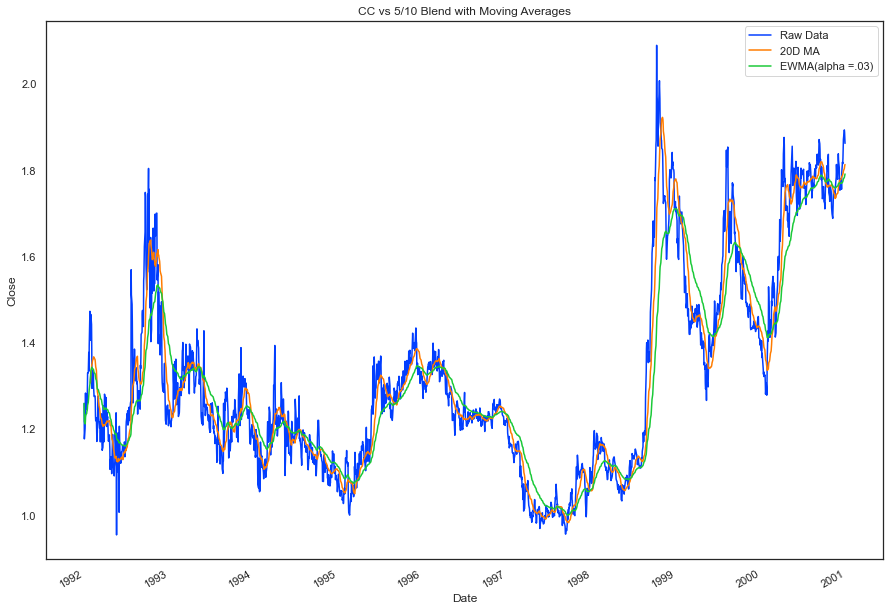

In [3]:
# Moving average chart for CC vs 5/10 Blend plotting the 1990s-2000s
f, ax = plt.subplots(figsize=(15,11))
early.CC.plot(label='Raw Data', ax=ax)
early.CC.rolling(20).mean().plot(label='20D MA', ax=ax)
early.CC.ewm(alpha=0.03).mean().plot(label='EWMA(alpha =.03)', ax=ax)

plt.title('CC vs 5/10 Blend' + " with Moving Averages")
plt.legend()
plt.xlabel("Date")
plt.gcf().autofmt_xdate()
plt.ylabel("Close")
plt.show()

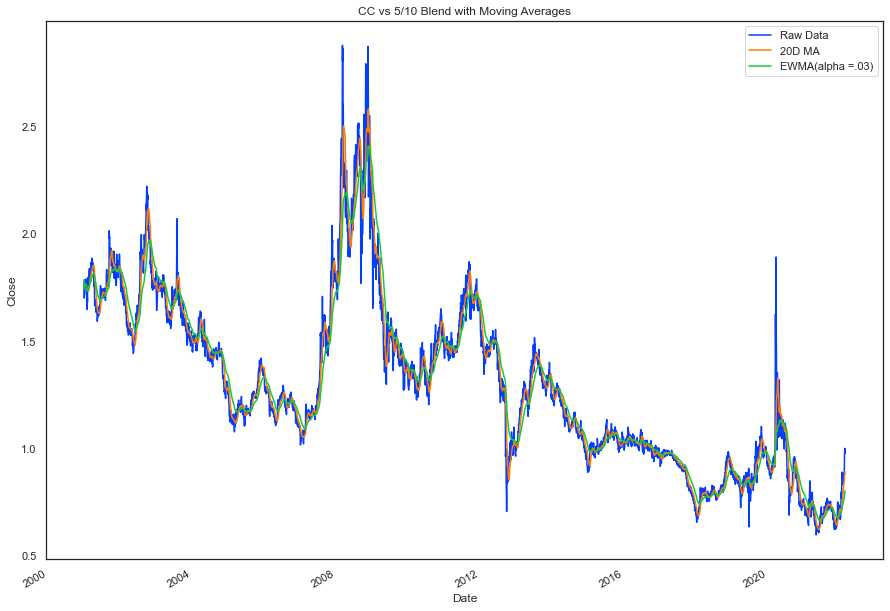

In [4]:
# Moving average chart for CC vs 5/10 Blend plotting the 1990s-2000s
f, ax = plt.subplots(figsize=(15,11))
late.CC.plot(label='Raw Data', ax=ax)
late.CC.rolling(20).mean().plot(label='20D MA', ax=ax)
late.CC.ewm(alpha=0.03).mean().plot(label='EWMA(alpha =.03)', ax=ax)

plt.title('CC vs 5/10 Blend' + " with Moving Averages")
plt.legend()
plt.xlabel("Date")
plt.gcf().autofmt_xdate()
plt.ylabel("Close")
plt.show()

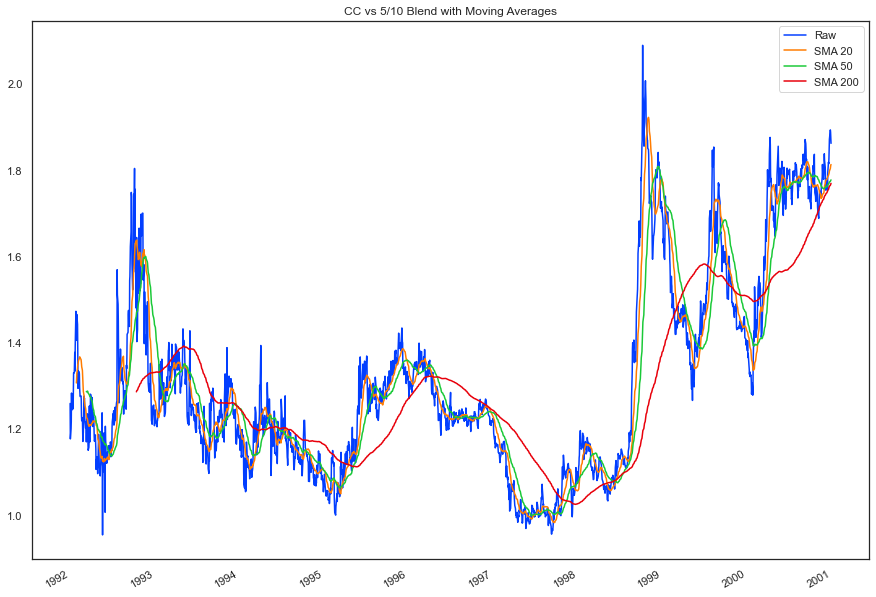

In [5]:
# Simple moving averages doing the early portion of data set.

sma20 = early.CC.rolling(20).mean()
sma50 = early.CC.rolling(50).mean()
sma200 = early.CC.rolling(200).mean()

smaplot =pd.DataFrame({'Raw': early.CC, 'SMA 20': sma20, 'SMA 50': sma50, 'SMA 200': sma200})
smaplot.plot(figsize=(15,11), legend=True, title="CC vs 5/10 Blend with Moving Averages")

plt.gcf().autofmt_xdate()
plt.show()

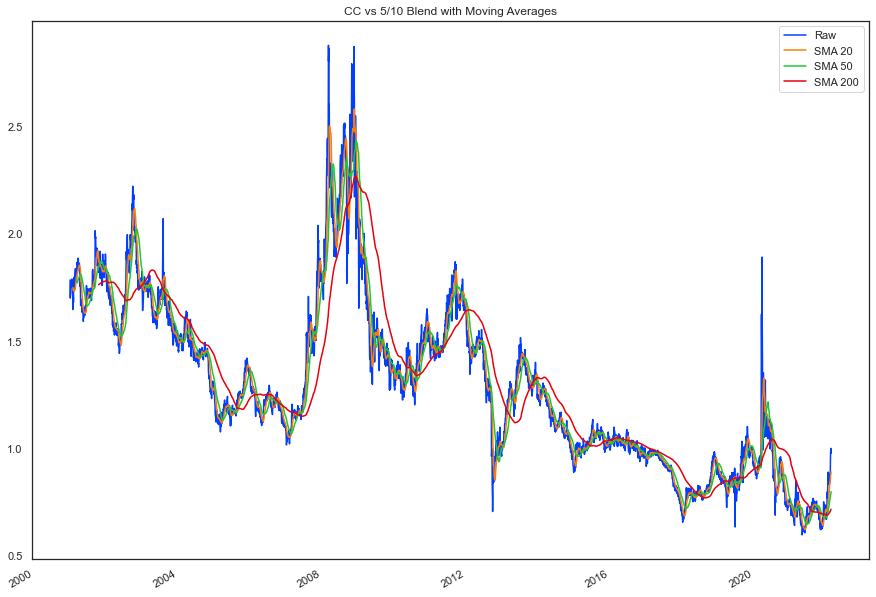

In [6]:
# Simple moving averages doing the late portion of data set.

sma20 = late.CC.rolling(20).mean()
sma50 = late.CC.rolling(50).mean()
sma200 = late.CC.rolling(200).mean()

smaplot =pd.DataFrame({'Raw': late.CC, 'SMA 20': sma20, 'SMA 50': sma50, 'SMA 200': sma200})
smaplot.plot(figsize=(15,11), legend=True, title="CC vs 5/10 Blend with Moving Averages")

plt.gcf().autofmt_xdate()
plt.show()

In [7]:
# Setting up the ARIMA model
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
from scipy.special import boxcox, inv_boxcox
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Resampling to monthly frequency. Start with the early data set
df_month = early.resample('M').mean()

Dickey–Fuller test: p=0.236410


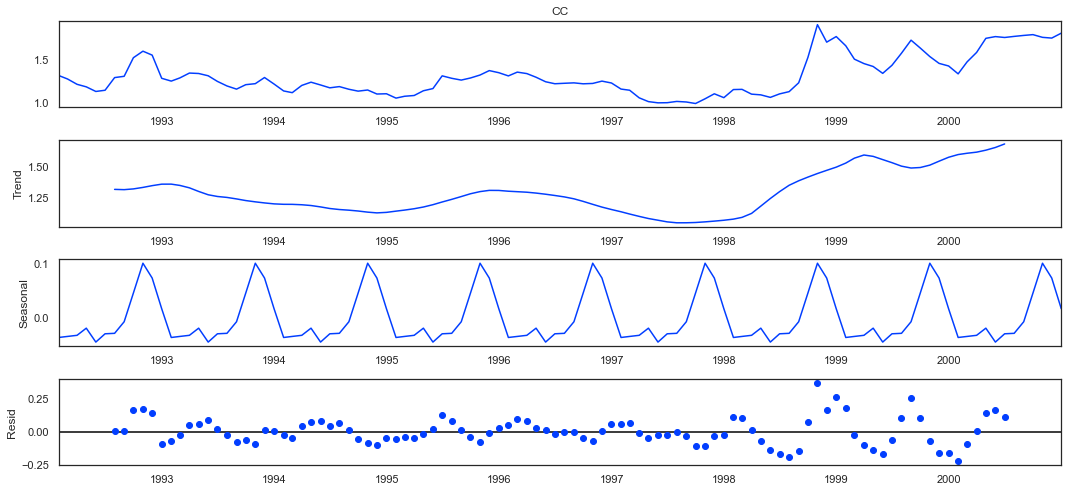

In [9]:
# Checking to see if data is stationary - it is not. Interseting seasonality thought which is expected. Stationary test would be a p-value of less than 0.05
seasonal_decompose(df_month.CC).plot()
print("Dickey–Fuller test: p=%f" % adfuller(df_month.CC)[1])
plt.show()

In [10]:
# Box-Cox Transformations - No Bueno in working
df_month['CC_box'], lmbda = stats.boxcox(df_month.CC)
print("Dickey–Fuller test: p=%f" % adfuller(df_month.CC_box)[1])

Dickey–Fuller test: p=0.205159


In [11]:
# Seasonal differentiation (12 months) - Not stationary
df_month['box_diff_seasonal_12'] = df_month.CC_box - df_month.CC_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(df_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.180746


In [12]:
# Seasonal differentiation (3 months) - Not stationary
df_month['box_diff_seasonal_3'] = df_month.CC_box - df_month.CC_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(df_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.000027


Dickey–Fuller test: p=0.000027


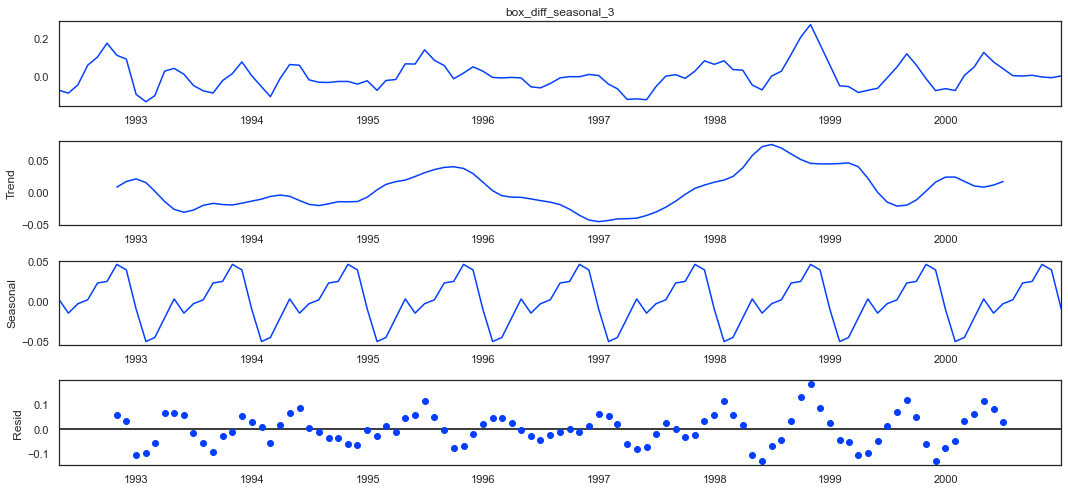

In [13]:
# Checking to see if data is stationary - it is not. Interseting seasonality thought which is expected. Stationary test would be a p-value of less than 0.05
seasonal_decompose(df_month.box_diff_seasonal_3[3:]).plot()
print("Dickey–Fuller test: p=%f" % adfuller(df_month.box_diff_seasonal_3[3:])[1])
plt.show()

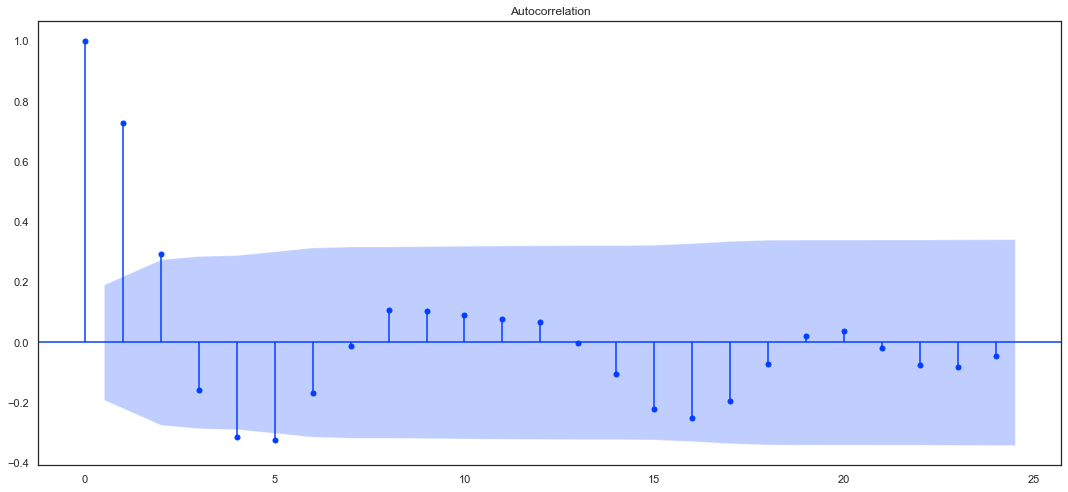

In [14]:
# Autocorrelation. Little bit rocky here.
plot_acf(df_month.box_diff_seasonal_3[3:].values.squeeze(), lags=24)

plt.tight_layout()
plt.show()

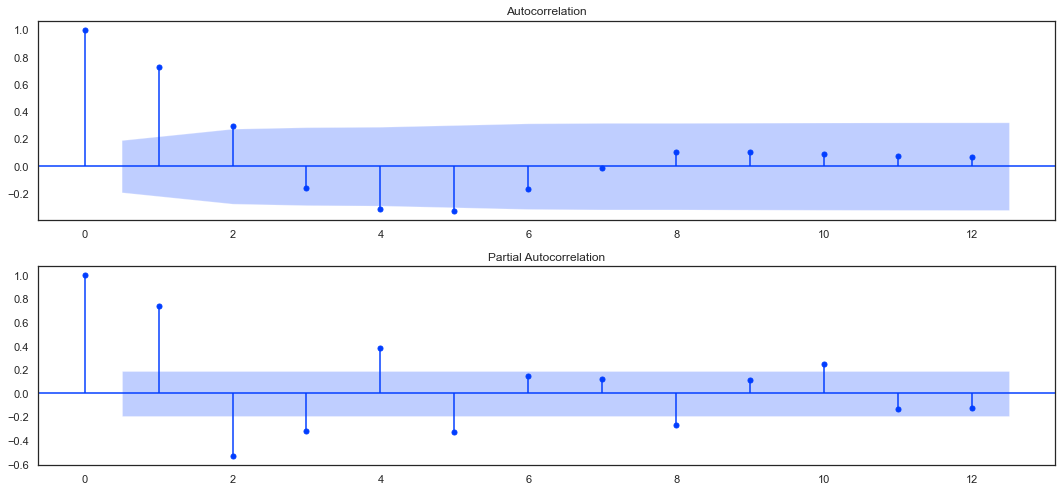

In [15]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots. Oof not great.
ax = plt.subplot(211)

# Plot the autocorrelation function
plot_acf(df_month.box_diff_seasonal_3[3:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)

plot_pacf(df_month.box_diff_seasonal_3[3:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

In [16]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(df_month.CC_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [17]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
8     (2, 2) -419.822479
3     (1, 0) -419.638115
7     (2, 1) -419.207533
1     (0, 1) -418.876112
2     (0, 2) -418.240583


In [18]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 CC_box   No. Observations:                  108
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 214.911
Date:                Mon, 28 Feb 2022   AIC                           -419.822
Time:                        18:07:11   BIC                           -406.458
Sample:                    01-31-1992   HQIC                          -414.405
                         - 12-31-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3333      0.231      5.769      0.000       0.880       1.786
ar.L2         -0.7110      0.190     -3.735      0.000      -1.084      -0.338
ma.L1         -1.0903      0.282     -3.867      0.0

In [19]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[3:])[1])

Dickey–Fuller test:: p=0.000000


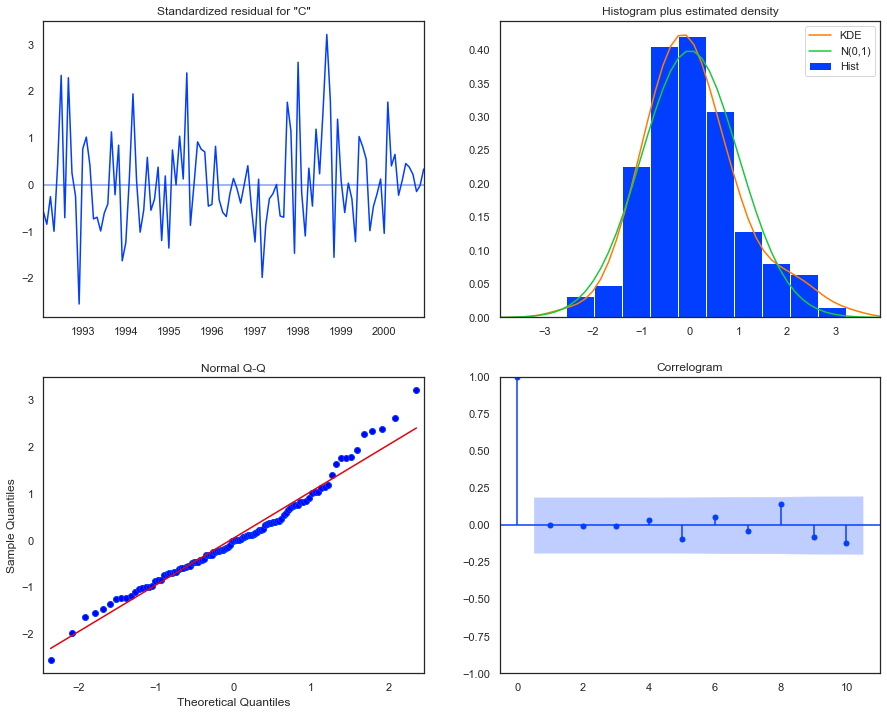

In [20]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [21]:
# Inverse Box-Cox Transformation Function - Box up some lambdas 
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

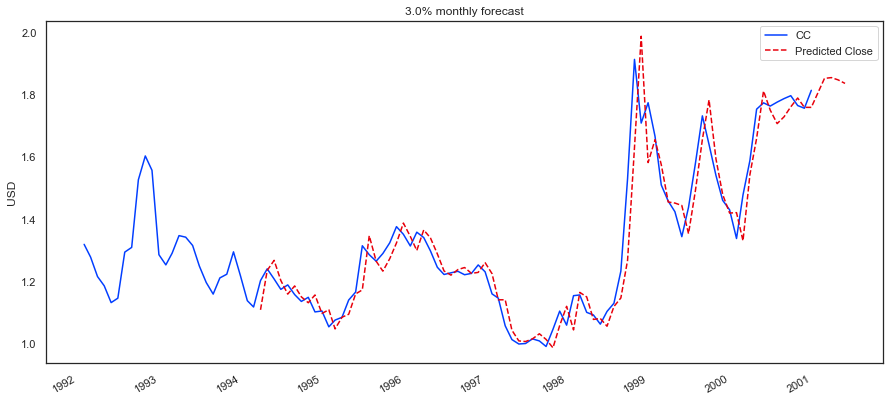

In [22]:
# Prediction
df_month_pred = df_month[['CC']]
date_list = [datetime(2001, 2, 28), datetime(2001, 3, 31), datetime(2001, 4, 30), datetime(2001, 5, 31)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month_pred = pd.concat([df_month_pred, future])

df_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(1994, 3, 31), end=datetime(2001, 5, 31)), lmbda)

plt.figure(figsize=(15,7))
df_month_pred.CC.plot()
df_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('3.0% monthly forecast')
plt.ylabel('USD')
plt.show()

In [23]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(df_month.CC_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [24]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
49  (2, 2, 0, 1) -389.679930
21  (1, 0, 1, 1) -389.642868
33  (1, 2, 1, 1) -389.378625
23  (1, 0, 2, 1) -389.242172
19  (1, 0, 0, 1) -389.204045
                                      SARIMAX Results                                      
Dep. Variable:                              CC_box   No. Observations:                  108
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 4)   Log Likelihood                 200.840
Date:                             Mon, 28 Feb 2022   AIC                           -389.680
Time:                                     18:07:30   BIC                           -373.872
Sample:                                 01-31-1992   HQIC                          -383.277
                                      - 12-31-2000                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

In [25]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


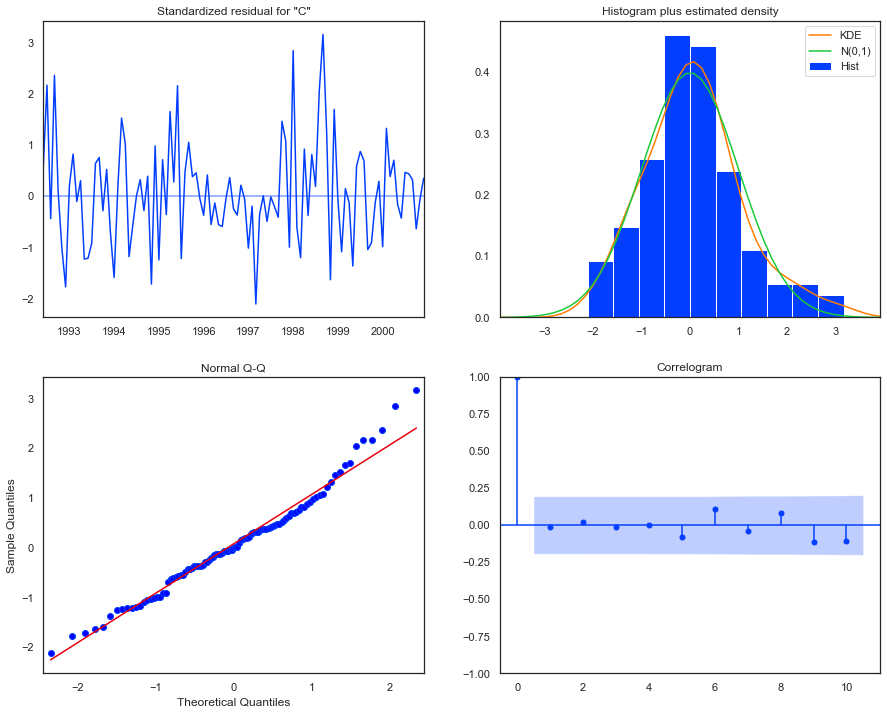

In [26]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.000000


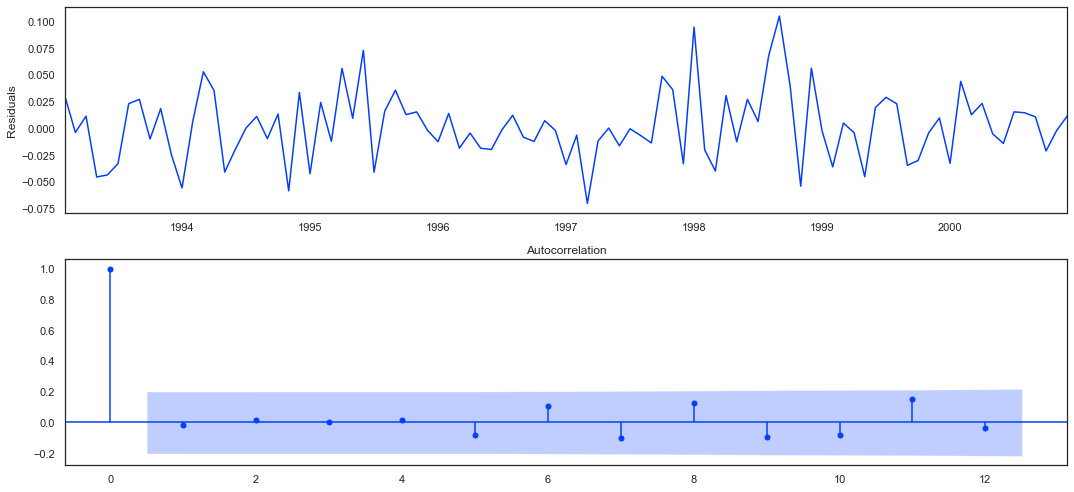

In [27]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

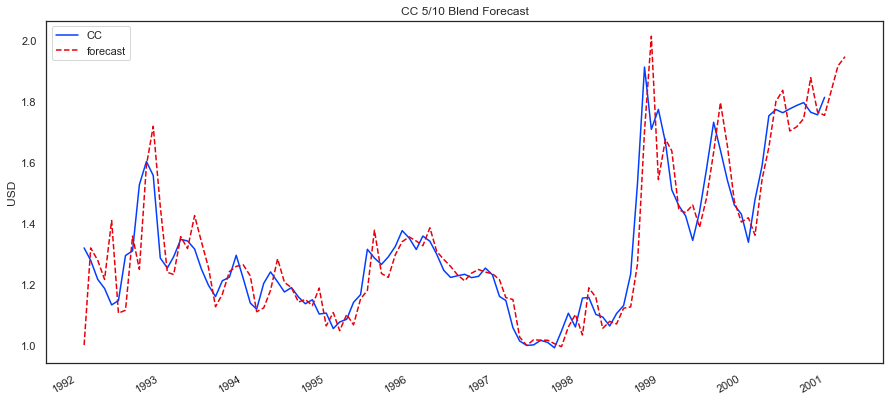

In [28]:
# Prediction
df_month2 = df_month[['CC']]
date_list = [datetime(2001, 2, 28), datetime(2001, 3, 31), datetime(2001, 4, 30), datetime(2001, 5, 31)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=110), lmbda)

plt.figure(figsize=(15,7))
df_month2.CC.plot()
df_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('CC 5/10 Blend Forecast')
plt.ylabel('USD')
plt.show()

In [29]:
# Damn good MSE

y_forecasted = df_month2.forecast
y_truth = df_month2['1994-01-02':'2001-01-04'].CC

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 0.08


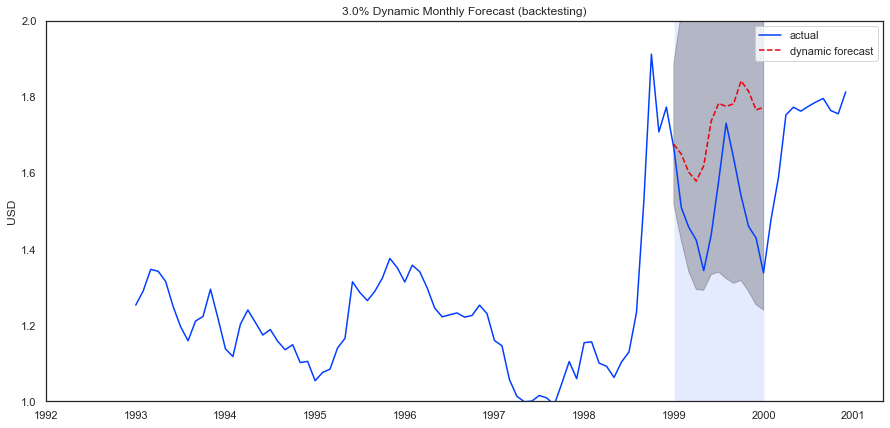

In [34]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('1999-01-31')
t2 = pd.to_datetime('2000-01-31')
df_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
df_month2['dynamic_forecast'] = invboxcox(df_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = df_month_dynamic.conf_int(alpha=0.20)
pred_dynamic_ci['lower CC_box'] = invboxcox(pred_dynamic_ci['lower CC_box'], lmbda)
pred_dynamic_ci['upper CC_box'] = invboxcox(pred_dynamic_ci['upper CC_box'], lmbda)

# Plot
plt.figure(figsize=(15,7))
plt.ylim((1.0, 2.0))

df_month2.CC['1993':'2001-01'].plot(label='actual')
df_month2.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast')

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('3.0% Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()

In [31]:
df_month.head(50)

,CC,CC_box,box_diff_seasonal_12,box_diff_seasonal_3
1992-01-31,1.318717,0.217755,NaN,NaN
1992-02-29,1.277693,0.198021,NaN,NaN
1992-03-31,1.215300,0.164360,NaN,NaN
1992-04-30,1.185685,0.146620,NaN,-0.071136
1992-05-31,1.131730,0.110896,NaN,-0.087125
1992-06-30,1.145916,0.120747,NaN,-0.043613
1992-07-31,1.293784,0.205971,NaN,0.059352
1992-08-31,1.308914,0.213197,NaN,0.102301
1992-09-30,1.525947,0.295609,NaN,0.174862
1992-10-31,1.602399,0.317423,NaN,0.111451
